# Neural Networks using PyTorch

This notebook implements a simple nural network model for classification of Fashion MNIST dataset.

This dataset contains grayscale images of 28x28 size of clothing items. There are 10 classes in total.

This notebook is more technical, focusing on how to read the data, instantiate a neural network model using PyTorch and train it as opposed to analyzing the results of classification and trying to build a very accurate model.

## Data Importing and Preprocessing

First of all we import clone the github directory containing relevant data. Training and testing datasets are already separated. Training dataset contains 60 000 images, while the test sample contains 10 000 entries of data.

In [1]:
import torch as pt
import numpy as np
import os

In [2]:
!git clone https://github.com/zalandoresearch/fashion-mnist data
os.listdir('data/data/fashion')

fatal: destination path 'data' already exists and is not an empty directory.


['train-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'unzipped',
 'train-labels-idx1-ubyte.gz',
 't10k-images-idx3-ubyte.gz']

In [3]:
# import mnist_reader:
import data.utils.mnist_reader as mnist_reader

# load data:
X_train_full, y_train_full = mnist_reader.load_mnist('data/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

In [4]:
X_train_full.shape, X_test.shape

((60000, 784), (10000, 784))

In [5]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

We want to further split the training dataset into training and validation splits. For that reason we perform a stratified split which ensures that the proportion of images in each class remains the same in both datasets. We take 50 % of the initial train sample as our actual train sample and the remaining 50 % as the validation sample.

We also need to normalize the data. As the grayscale has values in the range [0, 256] we can simply divide our initial data by 255.

In [6]:
from sklearn.model_selection import train_test_split

# normalize:
X_train_full = X_train_full / 255.

# split data:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,
                                                      test_size=0.5, shuffle=True,
                                                      stratify=y_train_full)

Let's give our classes names of actual items instead of numerical indices.

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

We can also print out an example of how our data looks as images.

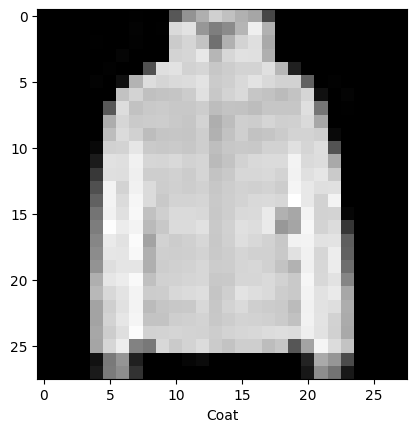

In [8]:
import matplotlib.pyplot as plt
i = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[i].reshape((28, 28)), cmap='gray') # cmap to make it recognize grayscale
plt.xlabel(class_names[y_train[i]])
plt.show()

## Dataset Loading Optimization

Loading all data at once at the time of instantiation is resources inefficient which can become very problematic with big datasets.

First of all we transform our data into a format more appropiate for big datasets.

In [9]:
target_dir = 'data/data/fashion/unzipped'
os.makedirs(target_dir, exist_ok=True)

train = mnist_reader.load_mnist('data/data/fashion', kind='train')
t10k  = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

data = np.concatenate((train[0], t10k[0]), axis=0)
labels = np.concatenate((train[1], t10k[1]), axis=0)

for i, x in enumerate(data):
  file = os.path.join(target_dir, f'img_{i:d}.npy')
  with open(file, 'wb') as f:
    np.save(f, x.reshape((28, 28)))

with open(os.path.join(target_dir, 'labels.npy'), 'wb') as f:
  np.save(f, labels)

Thus, we implement a class that loads a single sample dynamically from disk at the time of requestion hence minimizing the memory consumption.

This class also performs stratified splitting of the data into train, validation and test sets.

In [10]:
from numpy.typing import NDArray
from typing import Tuple
from torch.utils.data import Dataset

class FashionMNIST(Dataset):
  def __init__(self, indices:NDArray[np.int32], labels:NDArray[np.int8]) -> None:
    self.indices = indices
    self.labels = labels

  def __len__(self) -> int:
    return len(self.indices)

  def __getitem__(self, idx:int) -> Tuple[np.typing.NDArray, int]:
    dataset_index = self.indices[idx]
    # load image
    image_path = os.path.join(target_dir, f'img_{dataset_index:d}.npy')
    with open(image_path, 'rb') as f:
      img = np.load(f)

    # normalize
    img = img.astype(np.float32) / 255.
    img = img.flatten() # Flatten the image tensor
    img = pt.from_numpy(img) # Convert to PyTorch tensor

    # load label
    label = int(self.labels[idx])

    return img, label

  @staticmethod
  def create_split(fraction_train:float, fraction_validation:float, fraction_test:float, stratify:bool=True, shuffle:bool=True) -> Tuple[Dataset, Dataset, Dataset]:
    assert fraction_train + fraction_validation + fraction_test == 1.0

    with open(os.path.join(target_dir, 'labels.npy'), 'rb') as f:
      labels = np.load(f)

    indices = np.arange(len(labels), dtype=np.int32)

    stratify_param = labels if stratify else None

    # making test dataset
    idx_train_full, idx_test, y_train_full, y_test = train_test_split(indices, labels, test_size=fraction_test, shuffle=shuffle, stratify=stratify_param)

    # update fractions for train and validations
    new_val_frac = fraction_validation / (fraction_train + fraction_validation)
    stratify_param = y_train_full if stratify else None

    # split to train and validation
    idx_train, idx_val, y_train, y_val = train_test_split(idx_train_full, y_train_full, test_size=new_val_frac, shuffle=shuffle, stratify=stratify_param)

    data_train = FashionMNIST(
        idx_train,
        y_train
    )

    data_valid = FashionMNIST(
        idx_val,
        y_val
    )

    data_test = FashionMNIST(
        idx_test,
        y_test
    )

    return data_train, data_valid, data_test

Let's instantiate DataLoader objects for each of the datsets with shuffling and batching.

In [11]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

data_train, data_valid, data_test = FashionMNIST.create_split(.7, .1, .2)

In [12]:
loader_train = DataLoader(data_train,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          sampler=None,

                          batch_sampler=None,
                          drop_last=False)

Validation and test sets do not need to be shuffled since they all will be used at once.

In [13]:
loader_valid = DataLoader(data_valid,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

In [14]:
loader_test  = DataLoader(data_test,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

## Sequential Neural Network Model

In this part we implement a simple neural network architecture with given structure:

- One linear input layer of 300 perceptrons and *ReLu* activation function, followed by a dropout layer.

- One linear hidden layer of size 200, with a *ReLu* activation function, followed by a dropout layer.

- One linear output layer with *softmax* activation function.

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomNetwork(nn.Module):
  def __init__(self, dropout:float=.2) -> None:
    super().__init__()
    self.layer1 = nn.Linear(in_features=784, out_features=300, bias=True)
    self.dropout_layer1 = nn.Dropout(p=dropout)
    self.layer2 = nn.Linear(in_features=300, out_features=200, bias=True)
    self.dropout_layer2 = nn.Dropout(p=dropout)
    self.layer3 = nn.Linear(in_features=200, out_features=10, bias=True)

  def forward(self, x:pt.Tensor) -> pt.Tensor:
    x = F.relu(self.layer1(x))
    x = self.dropout_layer1(x)
    x = F.relu(self.layer2(x))
    x = self.dropout_layer2(x)
    return F.softmax(self.layer3(x), dim=-1)

## Neural Network Training

In this section model training loop is implemented. It uses:

- Momentum-based Adam optimizer
- Linear scheduler

The procedure also has early stopping functionality that stops the training when the validation loss has not improved for specified number of epochs (patience) and restores the model parameters to the ones where lowest loss was achieved

In [16]:
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
model = CustomNetwork()
model = model.to(device)

In [17]:
import pandas as pd
from sklearn.metrics import f1_score
from typing import Optional, Callable

def epoch(model:CustomNetwork, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
  model.train()

  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      # move tensors to correct device:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      # reset all gradients to zero:
      optimizer.zero_grad()

      # create predictions:
      y_pred = model(X_batch)

      # calculate loss:
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

      # backpropagate loss:
      loss.backward()

      # update weights:
      optimizer.step()

  return np.mean(losses)

def evaluate(model:CustomNetwork, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None):
  # 1. set model to eval:
  model.eval()

  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    # move tensors to correct device:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    labels.extend(y_batch.cpu().detach().numpy())

    # create predictions:
    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())

    # calculate loss:
    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

  # calculate f1 score:
  f1 = f1_score(
    y_batch.cpu().detach().numpy(),
    y_pred.argmax(dim=1).cpu().detach().numpy(),
    average='macro'
  )

  if loss_fn is None: return {'f1':f1}
  else: return {'loss':np.mean(losses), 'f1':f1}

def fit(model:CustomNetwork, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float, patience:int):
  # instantiate optimizer:
  optimizer = pt.optim.Adam(model.parameters(), lr=lr)

  # add scheduler
  scheduler = pt.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.33, total_iters=10)

  # instantiate loss function:
  loss_fn = pt.nn.CrossEntropyLoss()

  history = []
  best_loss = float('inf')
  best_state = None
  epochs_no_improvement = 0

  for i in range(epochs):
    # train for one epoch:
    loss_train = epoch(model, loader_train, optimizer, loss_fn)

    # evaluate on validation:
    metrics = evaluate(model, loader_valid, loss_fn)

    # save metrics:
    history.append({
      'loss_train':loss_train,
      'loss_valid': metrics['loss'],
      'f1_valid': metrics['f1']
    })

    # print message:
    print(f'Epoch {i+1:d}/{epochs:d}:', *[f'{metric} = {history[-1][metric]:.2f};' for metric in history[-1]], sep='\t')

    # early stopping:
    current_loss = metrics['loss']
    if current_loss < best_loss:
      best_loss = current_loss
      best_state = model.state_dict()
      epochs_no_improvement = 0
    else:
      epochs_no_improvement +=1
      if epochs_no_improvement >= patience:
        print(f'Early stopping triggered after {i+1} epochs.')
        break
    scheduler.step()
  model.load_state_dict(best_state)
  # return history:
  return pd.DataFrame(history)

Let's performing model training for 30 epochs with a learning rate of 0.001 and a patience of 5.

We also plot loss curves for train and validation samples.

Epoch 1/30:	loss_train = 1.80;	loss_valid = 1.71;	f1_valid = 0.78;
Epoch 2/30:	loss_train = 1.69;	loss_valid = 1.68;	f1_valid = 0.79;
Epoch 3/30:	loss_train = 1.69;	loss_valid = 1.70;	f1_valid = 0.79;
Epoch 4/30:	loss_train = 1.68;	loss_valid = 1.67;	f1_valid = 0.83;
Epoch 5/30:	loss_train = 1.68;	loss_valid = 1.68;	f1_valid = 0.83;
Epoch 6/30:	loss_train = 1.67;	loss_valid = 1.67;	f1_valid = 0.77;
Epoch 7/30:	loss_train = 1.67;	loss_valid = 1.68;	f1_valid = 0.79;
Epoch 8/30:	loss_train = 1.66;	loss_valid = 1.67;	f1_valid = 0.77;
Epoch 9/30:	loss_train = 1.66;	loss_valid = 1.67;	f1_valid = 0.81;
Epoch 10/30:	loss_train = 1.65;	loss_valid = 1.66;	f1_valid = 0.83;
Epoch 11/30:	loss_train = 1.65;	loss_valid = 1.66;	f1_valid = 0.83;
Epoch 12/30:	loss_train = 1.65;	loss_valid = 1.66;	f1_valid = 0.83;
Epoch 13/30:	loss_train = 1.65;	loss_valid = 1.66;	f1_valid = 0.80;
Epoch 14/30:	loss_train = 1.65;	loss_valid = 1.66;	f1_valid = 0.83;
Epoch 15/30:	loss_train = 1.65;	loss_valid = 1.65;	f1_val

<Axes: xlabel='epoch', ylabel='loss'>

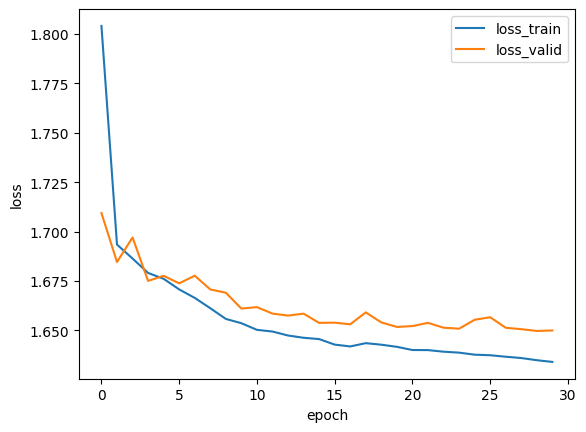

In [18]:
# train model:
history = fit(model, loader_train, loader_valid, epochs=30, lr=.001, patience=5)

# plot history:
history[['loss_train', 'loss_valid']].plot(xlabel='epoch', ylabel='loss')

Let's save the state dictionary of the resulting model

In [20]:
import pickle

with open('model_state_dict.pkl', 'wb') as f:
  pickle.dump(model.state_dict(), f)

with open('model_state_dict.pkl', 'rb') as f:
  state_dict = pickle.load(f)
model.load_state_dict(state_dict)
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
           Dropout-2                  [-1, 300]               0
            Linear-3                  [-1, 200]          60,200
           Dropout-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


##